# Soft Computing

## Vežba 3 - HOG

## Histogram of Oriented Gradients (HOG)

Jedan od najpopularnijih postupaka za izdvajanje osobina (eng. *feature extraction*) sa digitalne slike. Formalno, HOG je nešto što se zove **deskriptor slike** (eng. *image descriptor*), koji predstavlja opis vizuelnih osobina slike. Iako je predstavljen pre više od jedne dekade, tačnije 2005. godine u radu <a href="http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf">Histogram of Oriented Gradients for Human Detection</a>, HOG je deskriptor koji se i dan-danas vrlo često koristi za probleme detekcije i prepoznavanja objekata na slikama.

<img src="images/hog_diagram.png">

## Support Vector Machine (SVM)

SVM je model nadgledanog mašinskog učenja, koji se može koristiti za probleme klasifikacije i regresije. Ugrubo, SVM klasifikator konstruiše hiperravan koja "najbolje" razdvaja klase podataka, a ova "najbolja" hiperravan je zapravo ona koja maksimizuje marginu između podataka različitih klasa.

U svom osnovnom obliku, SVM je linearni klasifikator, tj. može vrlo efikasno da pronađe hiperravan koja maksimizuje marginu između linearno separabilnih podataka. Međutim, korišćenjem tzv. kernel trika (eng. *kernel trick*), moguće je konstruisati SVM za klasifikaciju podataka koji nisu linearno separabilni - tačnije, pomoću kernela se ulazni podaci zapravo mapiraju na neki višedimenzionalni prostor gde ti podaci postanu linearno separabilni. 

<img src="images/svm.png">

## Detekcija automobila

HOG i SVM ćemo iskoristiti kako bi rešili problem detekcije automobila na slikama iz <a href="http://cogcomp.org/Data/Car/">UIUC Image Database for Car Detection</a> skupa podataka. 

Trening skup **data/CarData/TrainImages** sadrži 1050 slika (pozitivnih i negativnih primera) dimenzija 100 x 40 za obučavanje i validaciju deskriptora i klasifikatora.

Test skup **data/CarData/TestImages** sadrži 170 slika različitih dimenzija za evaluaciju rada deskriptora i klasifikatora.

Rezultati rada deskriptora i klasifikatora na testnom skupu podataka se mogu uporediti sa tačnim lokacijama automobila koji se nalaze u **data/CarData/trueLocations.txt**.

### Obučavanje

In [2]:
import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt

import time
%matplotlib inline

In [4]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def display_image(image):
    plt.imshow(image, 'gray')

#### Primer pozitivnog uzorka - jeste automobil

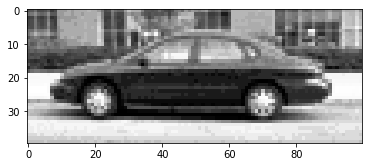

In [178]:
ipos = load_image('data/CarData/TrainImages/pos-1.pgm')

#ide x pa y velcina
dim = (200,80)
ipos2 = cv2.resize(ipos, dim, interpolation = cv2.INTER_AREA)
display_image(ipos)

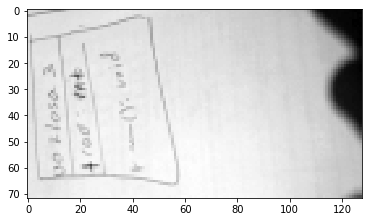

In [191]:
classd = load_image('data/ClassDiagram/positive/pos_1.jpg')


#x osa je 2048
#y osa je 1152  ---> odnos je oko 1.7777778 ---> ako stavis sirinu 128 ---> visina je 72

#ide x pa y velcina
dim = (128,72)
classd = cv2.resize(classd, dim, interpolation = cv2.INTER_AREA)
display_image(classd)

(80, 200)

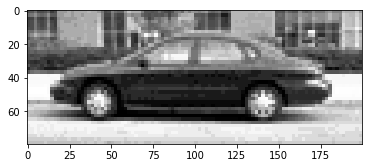

In [177]:
display_image(ipos)
ipos.shape

##### Primer negativnog uzorka - nije automobil

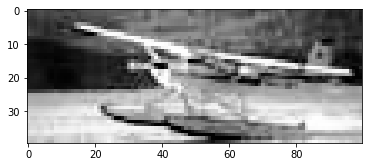

In [5]:
ineg = load_image('data/CarData/TrainImages/neg-0.pgm')
display_image(ineg)

In [6]:
ineg.shape

(40, 100)

#### Učitavanje svih primera

In [5]:
train_dir_classd_positive = 'data/ClassDiagram/class/positive/'
train_dir_classd_negative = 'data/ClassDiagram/class/negative/'

dim = (128,72)

pos_imgs_classd = []
neg_imgs_classd = []

for img_name in os.listdir(train_dir_classd_positive):
    img_path = os.path.join(train_dir_classd_positive, img_name)
    img_classd = load_image(img_path)
    if 'pos' in img_name:
        #da sve budu velicine 128*72
        img_classd = cv2.resize(img_classd, dim, interpolation = cv2.INTER_AREA)
        pos_imgs_classd.append(img_classd)
    
for img_name in os.listdir(train_dir_classd_negative):
    img_path = os.path.join(train_dir_classd_negative, img_name)
    img_classd = load_image(img_path)
    img_classd = cv2.resize(img_classd, dim, interpolation = cv2.INTER_AREA)
    neg_imgs_classd.append(img_classd)
        
        
print("Positive images #: ", len(pos_imgs_classd))
print("Negative images #: ", len(neg_imgs_classd))

Positive images #:  32
Negative images #:  65


In [6]:
train_dir = 'data/CarData/TrainImages/'

pos_imgs = []
neg_imgs = []

for img_name in os.listdir(train_dir):
    img_path = os.path.join(train_dir, img_name)
    img = load_image(img_path)
    if 'pos' in img_name:
        pos_imgs.append(img)
    elif 'neg' in img_name:
        neg_imgs.append(img)
        
print("Positive images #: ", len(pos_imgs))
print("Negative images #: ", len(neg_imgs))

Positive images #:  550
Negative images #:  500


#### Izračunavanje HOG deskriptora za sve slike i formiranje niza labela (1 = jeste automobil, 0 = nije automobil)

In [7]:
pos_features = []
neg_features = []
labels = []

nbins = 9 # broj binova
cell_size = (8, 8) # broj piksela po celiji
block_size = (3, 3) # broj celija po bloku

hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1], 
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)


#ORIGNALNO ONO KAKO JE BILO SA VEZBI
for img in pos_imgs:
    pos_features.append(hog.compute(img))
    labels.append(1)

for img in neg_imgs:
    neg_features.append(hog.compute(img))
    labels.append(0)

pos_features = np.array(pos_features)
neg_features = np.array(neg_features)
x = np.vstack((pos_features, neg_features)) #od 2 kolone napravi jednu
y = np.array(labels)



#za classDijagram

# pos_features_class = []
# neg_features_class = []
# labels_class = []


# hog_class = cv2.HOGDescriptor(_winSize=(img_classd.shape[1] // cell_size[1] * cell_size[1], 
#                                   img_classd.shape[0] // cell_size[0] * cell_size[0]),
#                         _blockSize=(block_size[1] * cell_size[1],
#                                     block_size[0] * cell_size[0]),
#                         _blockStride=(cell_size[1], cell_size[0]),
#                         _cellSize=(cell_size[1], cell_size[0]),
#                         _nbins=nbins)

# for img in pos_imgs_classd:
#     pos_features_class.append(hog_class.compute(img))
#     labels_class.append(1)

# for img in neg_imgs_classd:
#     neg_features_class.append(hog_class.compute(img))
#     labels_class.append(0)

# pos_features_class = np.array(pos_features_class)
# neg_features_class = np.array(neg_features_class)
# x_class = np.vstack((pos_features_class, neg_features_class)) #od 2 kolone napravi jednu
# y_class = np.array(labels_class)




#### Podela trening skupa na trening i validacioni 

In [534]:
# zamenjeno je x sa x_class i y sa y_class

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #0.2 posto je za trening
# x_train, x_test, y_train, y_test = train_test_split(x_class, y_class, test_size=0.2, random_state=42) #0.2 posto je za trening
print('Train shape: ', x_train.shape, y_train.shape)
print('Test shape: ', x_test.shape, y_test.shape)

Train shape:  (840, 2430, 1) (840,)
Test shape:  (210, 2430, 1) (210,)


In [535]:
# transformisemo u oblik pogodan za scikit-learn
def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))

x_train = reshape_data(x_train)
x_test = reshape_data(x_test)

In [536]:
print('Train shape: ', x_train.shape, y_train.shape)
print('Test shape: ', x_test.shape, y_test.shape)

Train shape:  (840, 2430) (840,)
Test shape:  (210, 2430) (210,)


#### Obučavanje i validacija SVM klasifikatora

In [537]:
clf_svm = SVC(kernel='linear', probability=True) 
clf_svm.fit(x_train, y_train)
y_train_pred = clf_svm.predict(x_train)
y_test_pred = clf_svm.predict(x_test)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

Train accuracy:  1.0
Validation accuracy:  0.9904761904761905


#### Obučavanje i validacija KNN klasifikatora

In [373]:
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn = clf_knn.fit(x_train, y_train)
y_train_pred = clf_knn.predict(x_train)
y_test_pred = clf_knn.predict(x_test)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

Train accuracy:  0.7974683544303798
Validation accuracy:  0.75


###### Sa oba klasifikatora koja smo isprobali, uvek smo dobili odlične rezultate (99+%). Kako ovo možemo protumačiti?

Pa prosto, ispostavlja se da je HOG deskriptor vrlo dobar alat za izdvajanje osobina objekata sa slike, i izgleda da su te izdvojene osobine relevantne prilikom klasifikacije. Odnosno, te osobine na neki reprezentativan način predstavljaju određenu vrstu objekta, što mi onda lako možemo iskoristiti za automatizaciju klasifikacije nekim od algoritama mašinskog učenja. 

### Testiranje

Dakle, sada imamo obučen SVM klasifikator koji vrlo precizno može da predvidi da li je nešto automobil ili ne. Međutim, ovaj klasifikator radi isključivo na slikama koje su dimenzija kao u obučavajućem skupu (100 x 40). U testnom skupu su date slike koje su različitih dimenzija (dosta veće od 100 x 40) i na kojima se nalaze automobili. Potrebno je detektovati <b>gde</b> se nalazi automobil na slici. 

#### Primer testne slike

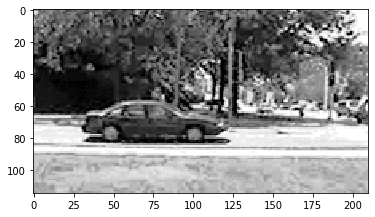

In [14]:
itest = load_image('data/CarData/TestImages/test-0.pgm')
display_image(itest)

Tehnika kojom bi ovo trebalo raditi jeste tzv. klizeći/klizni prozor (eng. <i>sliding window</i>), gde bi se na slici pomerao "prozor", veličine 100 x 40 i za svaki prozor se računao HOG deskriptor i zatim klasifikovao (da li je automobil ili ne). Zatim prozor pomerimo za recimo 10 piksela u desno i uradimo istu stvar. Naravno, kada dođemo do kraja reda, vratimo sliku skroz levo na početak i pomerimo je za recimo 10 piksela na dole i tako dalje.

Ovim ćemo za sve moguće prozore (dimenzija 100 x 40 i sa pomerajima [10px, 0px], [0px, 10px]) dobiti rezultate klasifikacije.

<img src="images/test-im-2.png">

Međutim, ovde nastaje problem - relativno je izvesno da ukoliko smo unutar jednog prozora detektovali automobil, da ćemo i u nekom od susednih prozora detektovati isti taj automobil (prosto, translacijom za samo 10 piksela smo dobili vrlo sličnu sliku i samim tim vrlo sličan HOG deskriptor koji je ulaz u SVM klasifikator). Dakle, neophodno je na neki način spojiti više bounding box-ova u jedan koji će biti konačan rezultat. Treba voditi računa i o slikama koje sadrže više od jednog automobila,a koje su prisutne u testnom skupu podataka. 

Prilikom računanja ovog konačnog bounding box-a može se uzeti u obzir i koliko je SVM siguran (eng. <i>confidence score</i>) u svoju odluku za određeni ulazni podatak - ovu vrednost je moguće dobiti pozivanjem metode <i>predict_proba</i> nad SVM klasifikatorom. Ova metoda vraća verovatnoću ishoda klasifikacije za svaku od klasa. Zbog toga smo u konstruktoru SVM klasifikatora morali staviti <i>probability=True</i>.

<img src="images/test-im-2-nms.png">

Konačni rezultati se mogu proveriti tako što će se uporediti sa lokacijama automobila u <b>data/CarData/trueLocations.txt</b>. U ovoj datoteci, svaka linija počinje sa rednim brojem slike iz testnog foldera, a istinska lokacija automobila na slici je definisana koordinatama gornje leve tačke (oblika: (y,x)) bounding box-a (dato u datoteci), a širina  visina bounding box-a su uvek 100px i 40px, respektivno (kao veličina slika u trening skupu). 

Dakle, ako u datoteci imamo <i>0: (48, 26)</i>, to znači da se na slici <i>data/CarData/TestImages/test-0.pgm</i> automobil nalazi na lokaciji koja je definisana bounding box-om <i>((48, 26), (48+40, 26+100)) = ((48, 26), (88, 126))</i>. Ako se u datoteci nalazi više koordinata u jednoj liniji, to znači da na toj slici ima više automobila.

Metrika kojom se meri poklapanje istinskog bounding box-a i dobijenog bounding box-a je <i>Jaccard index</i>, odnosno <i>IoU (Intersection over Union)</i>. Dakle, za dva bounding box-a, pronaći njihov presek i uniju, a zatim prebrojati piksele u preseku i u uniji i na kraju podeliti ova dva broja:

$$IoU=\frac{|A \cap B|}{|A \cup B|}$$

<img src="images/iou_viz.png">

Ukoliko je poklapanje potpuno, vrednost <i>IoU</i> će biti 1, ako poklapanja nema biće 0, u slučaju delimičnog poklapanja biće neka vrednost između 0 i 1. Vrednosti veće od 0.5 (tj. **IoU > 0.5**) se generalno smatraju "dobrom" predikcijom.
<img src="images/iou_examples.png">

### TODO:  

* Iskoristiti HOG i SVM za detektovanje automobila na slici iz testnog skupa podataka. 

#### Hint za implementaciju:  

* Implementirati metodu koja će računati HOG deskriptor i <i>confidence score</i> SVM klasifikatora za prosleđeni prozor. 
* Implementirati metodu koja će "obilaziti" sliku pomoću klizećeg/kliznog prozora i "pronalaziti" automobile.
* Implementirati metodu koja će računati <i>Jaccard index</i> za dva prosleđena bounding box-a.

In [538]:
def hogDescriptor(slide_window):  
    
    #promenjeno sa hog na hog_class
    features = hog.compute(slide_window).reshape(1,-1)
#     features = hog_class.compute(slide_window).reshape(1,-1)
    return clf_svm.predict_proba(features)[0][1]
    

In [12]:
def makeWindows(image, step_size, window_size = [100,40]):
    
    bestWindow = None
    bestScore = 0
    
#     img.shape[0] ---> ovo je y
#     image.shape[1] ---> je x
       
    
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            this_window = (y,x)
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if(window.shape == (window_size[1], window_size[0])):
                score = hogDescriptor(window)
                if(score > bestScore):
                    bestScore= score
                    bestWindow = this_window
                
    return bestScore, bestWindow
        
    

In [530]:
def JaccardIndex(win1, win2):
   
    #win1 je predikcija
    #win2 je pravi pravugaonik...

    x_a = max(win1[1], win2[1])
    y_a = max(win1[0], win2[0])
    
    x_b = min(win1[3], win2[3])
    y_b = min(win1[2], win2[2])
    
    inter_area = max(0, x_b-x_a + 1) * max(0, y_b-y_a + 1)
    
    true_area = (win2[3]-win2[1]+1) * (win2[2]-win2[0]+1)
    
    pred_area = (win1[3]-win1[1]+1) * (win1[2]-win1[0]+1)
    
    iou = inter_area / float(true_area + pred_area - inter_area)
    return max(iou,0)
    
    
        

In [546]:
def makeWindowsForNonMaximusSuppresion(image, step_size, window_size = [100,40]):
    
#     window_size = [128,72]
    #za automobile je bilo[100,40]
    #promenljeno je hog na 
    
    windows = []
#     img.shape[0] ---> ovo je y
#     image.shape[1] ---> je x
#     window = (y0,x0,y1,x1)

    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            this_window = (y, x, y+window_size[1], x+window_size[0])
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if(window.shape == (window_size[1], window_size[0])):
                score = hogDescriptor(window)
                if(score > 0.8):
                    windows.append((score, this_window))
                    #svi overlaping prozori sa ovim prozorom koji su trenutno sacuvani u windows
                    overlaping_windows = list(filter(lambda win: JaccardIndex(this_window, win[1]) > 0.3, windows))
                    #sortiras ih po score
                    overlaping_windows = sorted(overlaping_windows, key=lambda win: win[0], reverse=True)
                    #sve sem prvog obrises iz windows-a..
                    win = overlaping_windows[0]
                    windows = [winn for winn in windows if not winn in overlaping_windows]
                    windows.append(win)
    return windows
        
    

In [566]:
#moras nesto zakucati... ---> npr da kad fon slika to predje na 2048*1152 ili vece da predju na 1024 * 576
def makeImagePyramid(img):
    
    original_width = img.shape[1]
    original_height = img.shape[0]
    
    pyramid_of_images = {}
#     percentages = [1, 0.9, 0.75, 0.6, 0.5]
    percentages = [1, 0.9, 0.8, 0.75, 0.5, 0.25]
    for percentage in percentages:
        dimensions = (int(original_width * percentage), int(original_height * percentage))
        img_pyramid = cv2.resize(img, dimensions, interpolation = cv2.INTER_AREA)
        
        pyramid_of_images[percentage] = img_pyramid
        
    return pyramid_of_images

In [541]:
def readjustSlidingWindows(windows, percentage):
    resized_windows = []

    for window in windows:
        if window:
            score = window[0]
            start_point = (window[1][1] / percentage, window[1][0] / percentage)
            end_point = (window[1][3]/ percentage, window[1][2] / percentage)
            resized_windows.append((score, (int(start_point[1]), int(start_point[0]), int(end_point[1]), int(end_point[0]) )))
    return resized_windows
    

In [542]:
def NMS(windows, threshold):
    nms_windows = []

    while(len(windows) > 0):
        current_window = windows[0]
        overlaping_windows = list(filter(lambda win: JaccardIndex(current_window[1], win[1]) > threshold, windows))
        #sortiras ih po score
        overlaping_windows = sorted(overlaping_windows, key=lambda win: win[0], reverse=True)
        #sve sem prvog obrises iz windows-a..
        best_window = overlaping_windows[0]
        
        nms_windows.append(best_window)
        windows = [winn for winn in windows if not winn in overlaping_windows]
        
    return nms_windows

[(0.9999999998020354, (25, 55, 65, 155))]


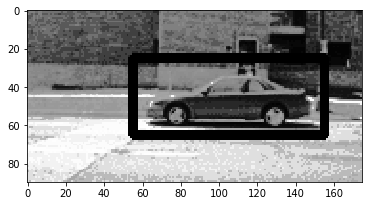

In [155]:
itest2 = load_image('data/CarData/TestImages/test-2.pgm')
# display_image(itest2)

# score, window = makeWindows(itest2,10) # window je y,x
# print(score)
# print(window)


windows = makeWindowsForNonMaximusSuppresion(itest2,5) # window je y,x
print(windows)

for window in windows:
    score = window[0]
    start_point = (window[1][1],window[1][0])
    end_point = (window[1][3],window[1][2])
    cv2.rectangle(itest2, start_point, end_point, (0), 4) 

    
display_image(itest2)

[(0.9999984989603011, (30, 20, 70, 120))]


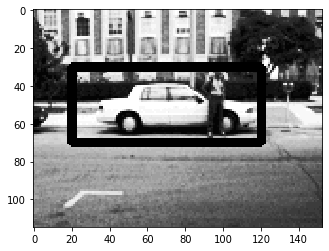

In [593]:
# itest_class = load_image('data/ClassDiagram/test/6.jpg')
# print(itest_class.shape)

# dim2 = (288,512)
# test_class = cv2.resize(itest_class, dim2, interpolation = cv2.INTER_AREA)
# display_image(itest_class)



itest_class = load_image('data/CarData/TestImages/test-41.pgm')

# #treba da udje siva slika koja je dimenzija 1024 * 576(sirina)
final_windows = []
windows_pyramid = {}

pyramid = makeImagePyramid(itest_class)
for p in pyramid:
    pyramid_img = pyramid[p]
    windows = makeWindowsForNonMaximusSuppresion(pyramid_img,10)
    # sta cu sa prozorima koji su dobri za male slike.... ===> ako se preklope sa prozorom sa vece
    # slike ---> tj pokusaju isti objekat da oivice...
    
    # dobio si najbolje prozore za odredjenu sliku iz piramide
    # da li te prozore treba skalirati ili sta vec...
    # msm realno prozor ako prilagodis po najvecoj slici --> i ok on ce da se nacrta te velicine
    # na slici i obuhvatice objekat koji su prepoznati na najvecoj,
    # za umanjene slike(tu ce mozda da prepozna neke objekte koji su preveliki bili na orginalnoj slici)
    # a sad na umanjenjenoj su okej ---> te prozore moras da nekako povecas i da izracunas odakle sad oni pocinju
    # fora kad budes ima sve prozore prilagodjene onda opet moras da uradis NMS jer ce mozda neki
    # sa razlicitih velicina da prepoznaju isti objekat???
    windows_pyramid[p] = windows

# print(windows_pyramid)  
for p in windows_pyramid:
    new_windows = readjustSlidingWindows(windows_pyramid[p], p)
    for win in new_windows:
        final_windows.append(win)
        
# # treba da se uradi NMS globalni
final_windows = NMS(final_windows, 0.51)

for window in final_windows:
    score = window[0]
    start_point = (window[1][1],window[1][0])
    end_point = (window[1][3],window[1][2])
    cv2.rectangle(itest_class, start_point, end_point, (0), 4) 

print(final_windows)
display_image(itest_class)

(576, 1024)
(295, 10)
(423, 82)


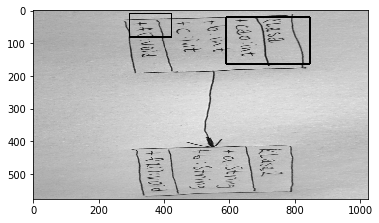

In [251]:
itest_class2 = load_image('data/ClassDiagram/test/1.jpg')
dim2 = (1024,576)
itest_class2 = cv2.resize(itest_class2, dim2, interpolation = cv2.INTER_AREA)

s_point = (295,10)
e_point = (423,82)

s2_point = (295*2,10*2)
e2_point = (423*2,82*2)
print(itest_class2.shape)
print(s_point)
print(e_point)
cv2.rectangle(itest_class2, s_point, e_point, (0,0,0), 4)
cv2.rectangle(itest_class2, s2_point, e2_point, (0,0,0), 4)
display_image(itest_class2)






True

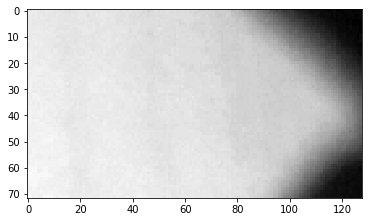

In [407]:
itest_class = load_image('data/ClassDiagram/class/positive/pos_1.jpg')
# display_image(itest_class)
#problem je kad je na slici velika klasa ---> tj veca od sliding window-a.


#     (20, 200, 92, 328) ---> cista veza izmedju klasa
#     (120, 320, 192, 448) ---> cista veza izmedju klasa

# (60, 350, 132, 478)
# 100, 120, 172, 248
# 30, 370, 102, 498


dim2 = (512,308)
itest_class = cv2.resize(itest_class, dim2, interpolation = cv2.INTER_AREA)
display_image(itest_class)
crop_img = itest_class[30:102,370:498]

# crop_img_resize = cv2.resize(itest_class, dim2, interpolation = cv2.INTER_AREA)
display_image(crop_img)

cv2.imwrite("data/ClassDiagram/class/negative/neg_8.jpg", crop_img) 

# makeSamples("negative", crop_img)



In [281]:
#moras rucno proci kroz to sto napravi pa da budes siguran da to sto je kreirao zapravo je dobar/los sample
def makeSamples(folder_path, img):
    
    current_milli_time = lambda: int(round(time.time() * 1000))
    
    num_rows, num_cols = img.shape[:2]
    angles = [0, 45, 90, 135, 180, 270]
    for angle in angles:
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), angle, 1)
        img_rotation = cv2.warpAffine(img, rotation_matrix, (num_cols, num_rows))        
        img_final_path = folder_path + str(current_milli_time()) + ".jpg"
        cv2.imwrite(img_final_path, img_rotation) 
        time.sleep(1.5)

    

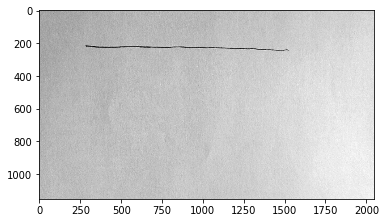

In [408]:
#make some positive samples
img_pos = load_image('data/ClassDiagram/arrows/positive/pos_2.jpg')
display_image(img_pos)


# img_path = "data/ClassDiagram/class/positive/pos_"


makeSamples(img_path, crop_img)


## Zadaci

### Zadatak 1 

Proveriti dobijene rezultate sa tačnim lokacijama automobila za sve slike iz testnog skupa. Izračunati uspešnost postupka (broj uspešno detektovanih automobila (IoU > 0.5) podeliti sa ukupnim brojem automobila iz testnog skupa).  
Hint za slike koje sadrže više od jednog automobila: **Non-Maximum Suppression**.

### Zadatak 2 - Konji

U <b>data/HorsesData/</b> se nalazi modifikovan <b>INRIA horse dataset</b> za detekciju konja na slici. Sve slike su u boji, i različitih su dimenzija.

Skup podataka je modifikovan tako da:

* folder <b>data/HorsesData/neg</b> sadrži 170 slika negativnog uzorka (nije konj).
* folder <b>data/HorsesData/pos</b> sadrži 120 slika pozitivnog uzorka (jeste konj) sa pripadajućim <b>groundtruth</b> datotekama sa tačnim bounding box-om konja na slici. 
* folder <b>data/HorsesData/test</b> sadrži 50 testnih slika sa konjima i pripadajućim <b>groundtruth</b> datotekama.

<b>Groundtruth</b> datoteke su imenovane po šablonu: <i><b>imeSlike</b>__entires.groundtruth</i>.  
Koordinate rezultujućeg bounding box-a u <b>groundtruth</b> datotekama su date u sledećem formatu:

<i>top_left_x  top_left_y  bottom_right_x  bottom_right_y</i>

Prilikom testiranja, za poređenje bounding box-ova koristiti <i>Jaccard index</i>. 

In [ ]:
googleDataSet = "~/Documents/Semestar7/Soft/projekat/google_drive_dataset/soft_dataset-20200110T155914Z-001/soft_dataset/strelice/asocijacija"

for img_name in os.listdir(googleDataSet):
    imagePath = os.path.join(googleDataSet, img_name)
    image = cv2.imread(imagePath)
    
    plt.imshow(image)
    break
    
    
# image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
# image = img_to_array(image)
# data.append(image)
# cv2.imwrite("data/ClassDiagram/class/negative/neg_8.jpg", crop_img) 



